In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math
import scipy.fft as fft
from functools import partial
from scipy import signal

In [2]:
sampling = 0.01

plt.rcParams['figure.figsize'] = [11, 13]
plt.rcParams['figure.dpi'] = 100

x = np.arange(-4, 4, sampling)

In [3]:
def FFT(data):
    return fft.fft(data, len(data))
def iFFT(data):
    return fft.ifft(data)

#get axis to plot FT on
def getFreqAxis(x):
    return np.fft.fftfreq(len(x), d=sampling)
def flipAtOrigin(data):
    tmp = np.split(data, 2)
    return np.concatenate([tmp[1], tmp[0]])
def rect(w, x):
    return 1 if np.abs(x)<=w else 0

In [4]:
def rollingAverage (data, radius = 1.0):
    radius /= sampling
    radius = int(radius)
    
    out = np.zeros(len(data))
    for i in range(len(data)):
        count = 0
        sum_val = 0
        for j in range(-radius, radius):
            count+=1
            sum_val += data[i+j] if 0 <= i+j < len(data)  else 0
        out[i] = sum_val/count
    return out

In [5]:
def plotFreq(axs, data, label = None, color = 'red'):
    freqAxis = np.fft.fftfreq(len(x), d=sampling)
    freqAxis = freqAxis[:len(freqAxis)//2]
    axs.plot(freqAxis, np.abs(np.split(data, 2)[0]), label = label, color = color)
    axs.grid()
    axs.legend()
    
def getFreqPlot(data, label):
    freqAxis = np.fft.fftfreq(len(x), d=sampling)
    freqAxis = freqAxis[:len(freqAxis)//2]
    return {'data': np.abs(np.split(data, 2)[0]), 'label': label, 'x': freqAxis}

In [6]:
def lowPassFilterPerfect(w, x):
    return 1.0 if np.abs(x) < w else 0

In [7]:
def lowPass(w, x, values):
    freqAxis = np.fft.fftfreq(len(x), d=sampling)

    data = np.vectorize(partial(lowPassFilterPerfect, w), otypes=[np.complex128])(freqAxis)
    fil = np.fft.ifft(data)
    fil = flipAtOrigin(fil)
    
    r_fil = rollingAverage(np.vectorize(partial(rect, 1.0))(x), 1.0)*fil
    
    filtered = np.convolve(r_fil, values, 'same')
    return filtered

def highPass(w, x, values):
    return values - lowPass(w, x, values)

def bandPass(a, b, x, values):
    return highPass(a, x, lowPass(b, x, values))

def bandStop(a, b, x, values):
    return values - bandPass(a, b, x, values)

In [8]:
def squareWave(period, x):
    return signal.square(2 * np.pi * period * x)

In [9]:
def getFilterResponse(filt):
    freqAxis = getFreqAxis(x)
    graph = np.zeros(len(freqAxis))
    tmp = np.zeros_like(freqAxis)
    tmp[0]=1
    return np.abs(FFT(filt(x,tmp))) 

In [10]:
def showPlots(plots):
    colors = ['#06d6a0', '#277da1', '#ee6c4d','#5a189a','#f3722c']
    plotCount = 0
    
    for i in range(len(plots)):
        if 'same' not in plots[i] or plots[i]['same'] == False:
            plotCount+=1
            
    fig, axs = plt.subplots(plotCount)
    pid = 0
    for i in range(len(plots)):
        if 'same' in plots[i] and plots[i]['same'] == True and pid > 0:
            pid -= 1            
        if 'x' not in plots[i]:
            axs[pid].plot(plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
        else:
            axs[pid].plot(plots[i]['x'], plots[i]['data'], label = plots[i]['label'], color = colors[i%len(colors)])
        axs[pid].grid()
        axs[pid].legend()
        
        pid+=1

In [11]:
def show(data, filterFunc):
    fftData = FFT(data)
    
    filtered = filterFunc(x, data)
        
    filterResponse = getFilterResponse(filterFunc)
    
    showPlots([getFreqPlot(FFT(data), "original freq. response"), 
              {'data': data, 'label': 'original', 'x': x},
              {'data': np.real(filtered), 'label': 'filtered', 'x': x, 'same': True},
               getFreqPlot(FFT(filtered), "filtered freq. response"),
               getFreqPlot(getFilterResponse(filterFunc), "filter freq. response")])

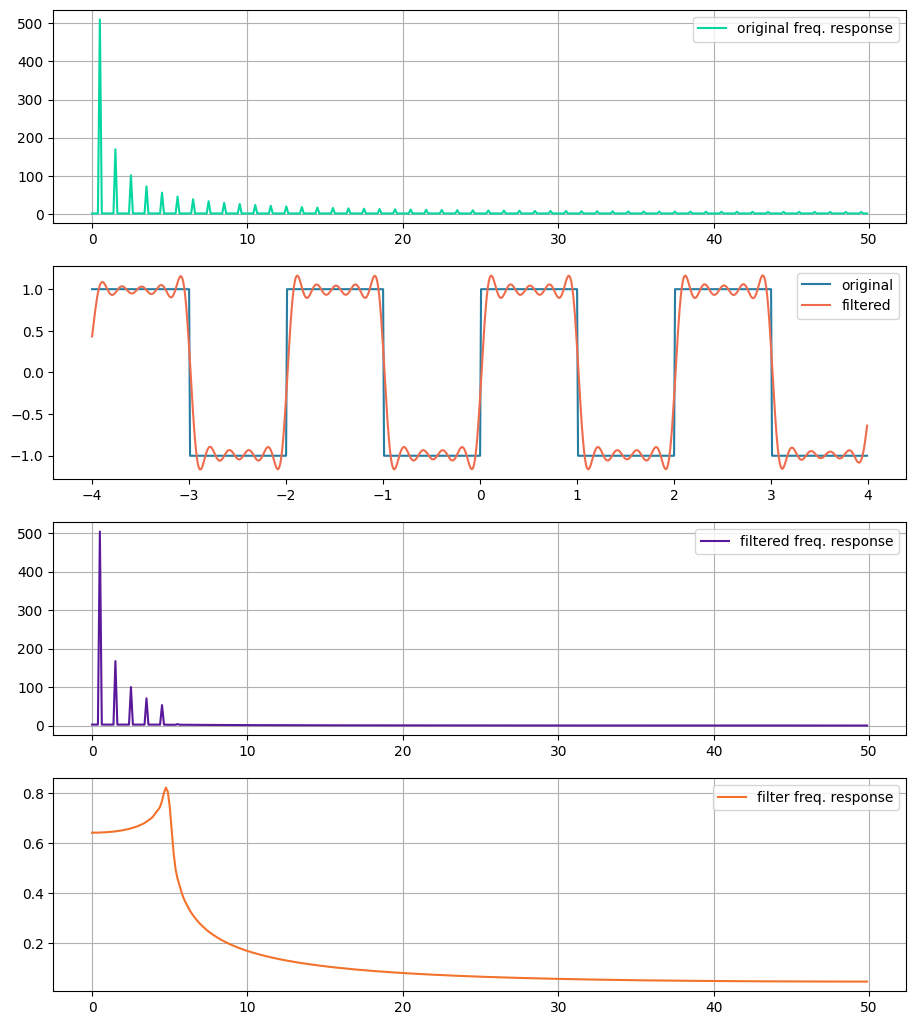

In [12]:
data = np.vectorize(partial(squareWave, 0.5))(x)
show(data, partial(lowPass, 5))

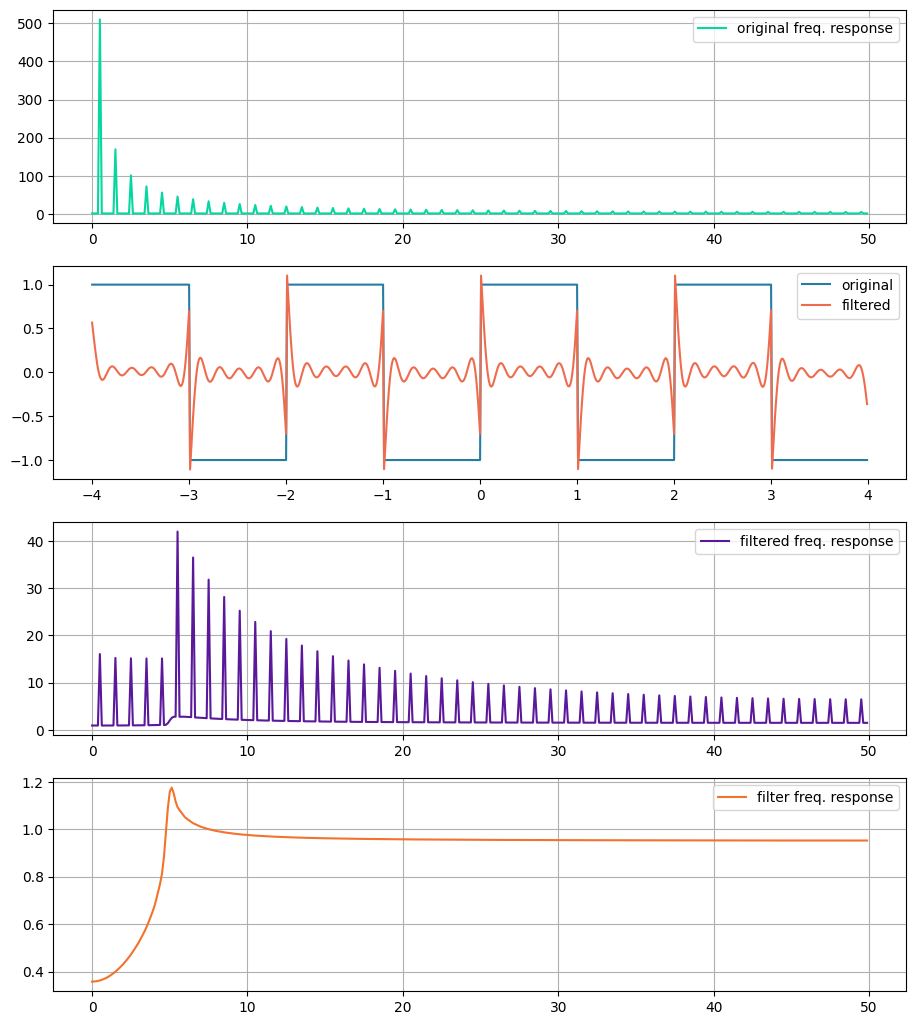

In [13]:
data = np.vectorize(partial(squareWave, 0.5))(x)
show(data, partial(highPass, 5))

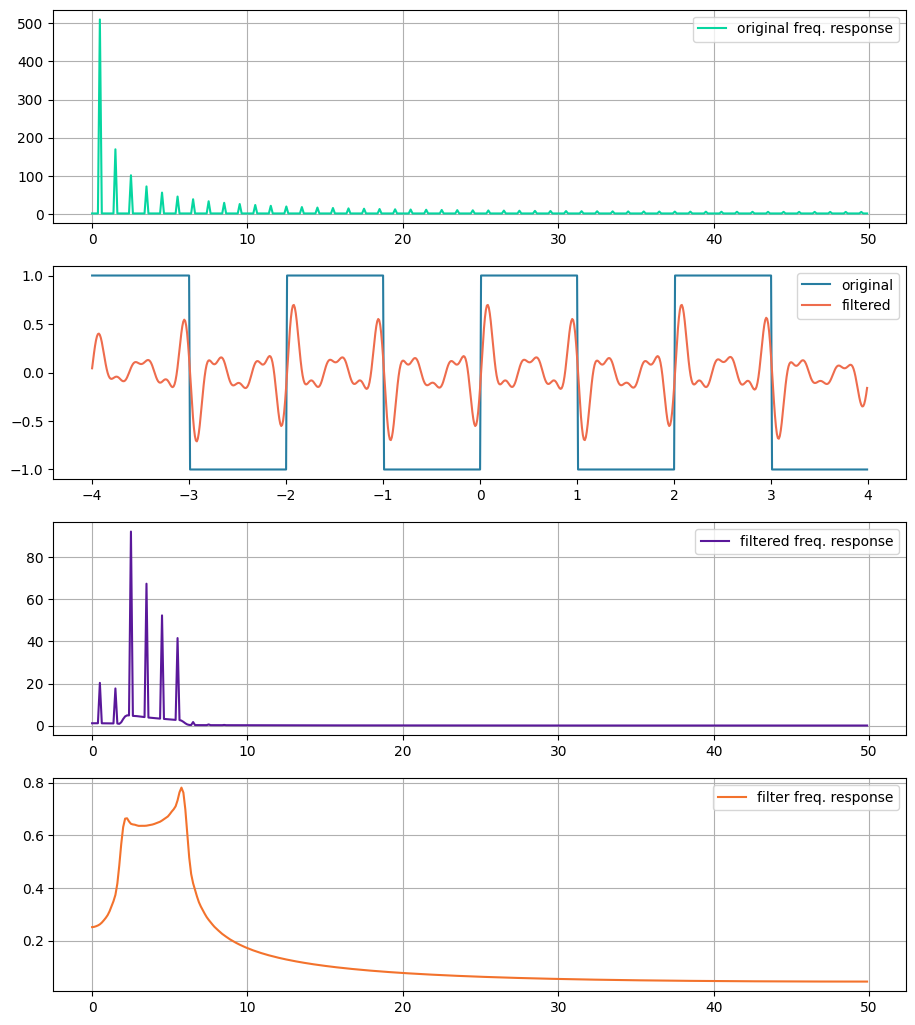

In [14]:
data = np.vectorize(partial(squareWave, 0.5))(x)
show(data, partial(bandPass, 2, 6))

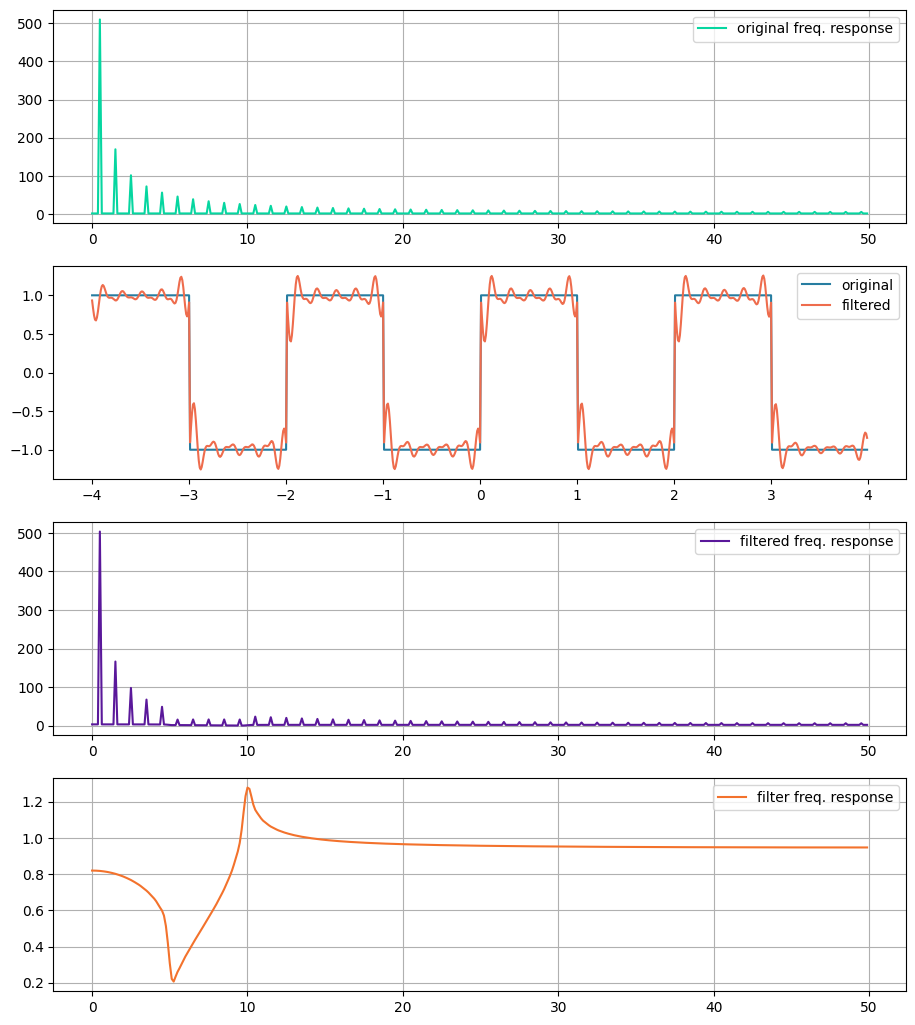

In [15]:
data = np.vectorize(partial(squareWave, 0.5))(x)
show(data, partial(bandStop, 5, 10))

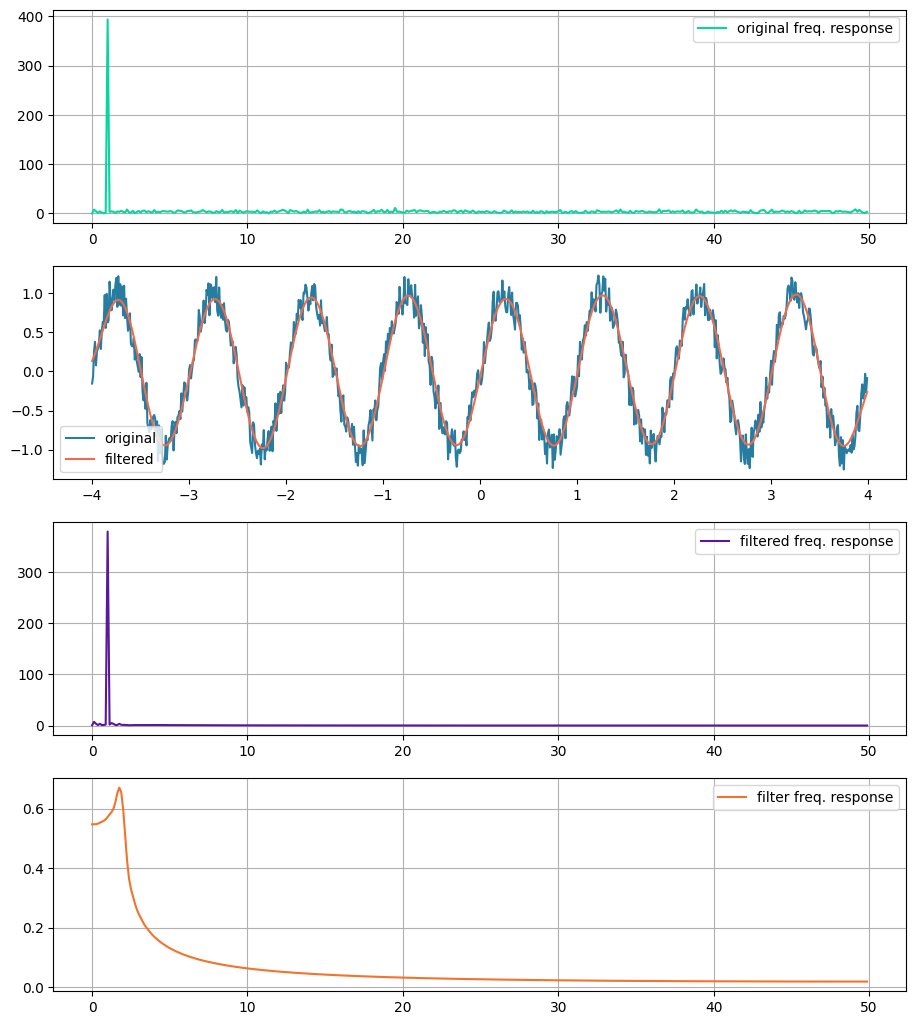

In [19]:
data = np.random.random(len(x))
data -= np.mean(data)
data = np.sin(2*np.pi*x) + data*0.5
show(data, partial(lowPass, 2))

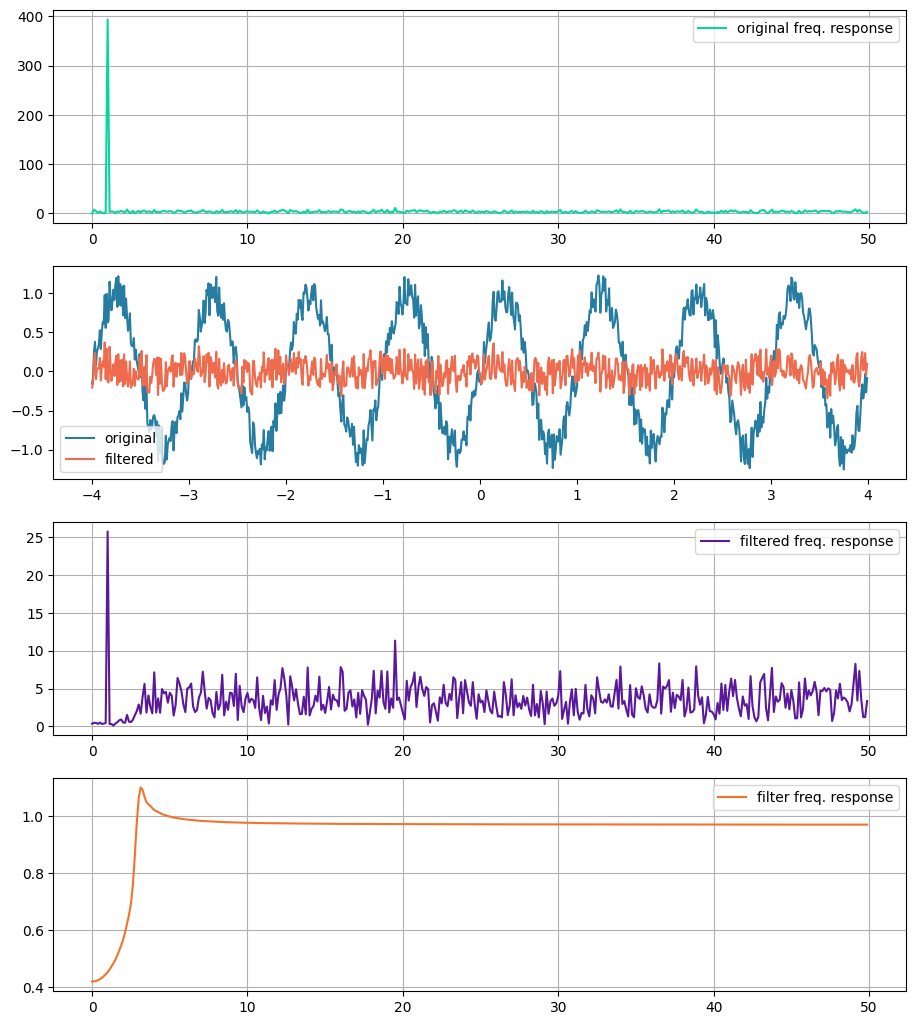

In [21]:
show(data, partial(highPass, 3))